In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


## Imports

In [2]:
import optuna
import torch
import cv2

import torch.optim as torch_optim
import torch.optim.lr_scheduler as torch_lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import lightgbm as lgbm
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import ndimage

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error

from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier, cv, CatBoostRegressor

from optuna.visualization.matplotlib import plot_param_importances

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

%matplotlib inline
data_path = '/kaggle/input/digit-recognizer/'

np.random.seed(42)

## Loading Data

In [3]:
df = pd.read_csv(os.path.join(data_path, 'train.csv'))
X, y = df.drop('label', axis=1).values, df['label'].values

X = X.reshape(-1, 28, 28) / 255

## Data Visualization 

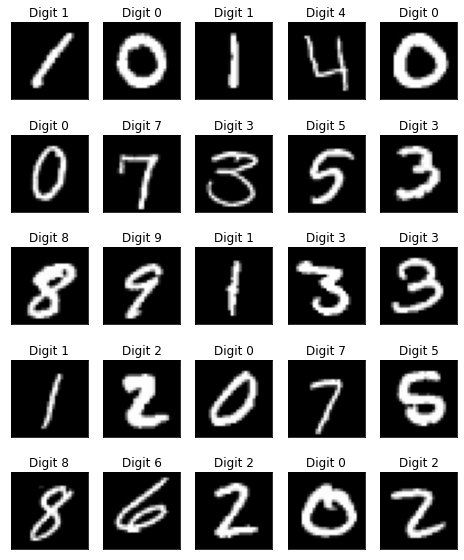

We have 42000 training images with (28, 28) H*W.
Value ranges for each image is between 0.0 and 1.0.
We have 10 classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].


In [4]:
def plot_grid(X, y):
    fig, axm = plt.subplots(nrows=5, ncols=5, figsize=(8, 10))

    for i, axs in enumerate(axm):
        for j, ax in enumerate(axs):
            idx = i * 5 + j
            ax.imshow(X[idx], cmap='gray')
            ax.set_title(f'Digit {y[idx]}')
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)

    plt.show()

    print(f'We have {X.shape[0]} training images with {X.shape[1:]} H*W.')
    print(f'Value ranges for each image is between {X.min()} and {X.max()}.')
    print(f'We have {len(np.unique(y))} classes: {list(np.unique(y))}.')
    
plot_grid(X, y)

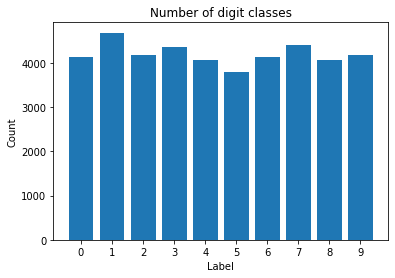

In [5]:
keys, counts = np.unique(y, return_counts=True)

plt.bar(keys, counts)

plt.xticks(range(0, 10))
plt.title("Number of digit classes")
plt.ylabel("Count")
plt.xlabel("Label")
plt.show()

## Modeling



### Baseline

In [6]:
(X_train, X_test, y_train, y_test) = train_test_split(X.reshape(-1, 28 * 28), y, train_size=0.8, stratify=y, random_state=42)

logreg = LogisticRegression(solver='liblinear')

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f"Accuracy score {accuracy_score(y_test, y_pred)}")
print(f"F1 score {f1_score(y_test, y_pred, average='weighted')}")
print(f"Precision score {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"Recall score {recall_score(y_test, y_pred, average='weighted', zero_division=0)}")

Accuracy score 0.9110714285714285
F1 score 0.9107677893823565
Precision score 0.9107032022517122
Recall score 0.9110714285714285


### SVC

In [7]:
(X_train, X_test, y_train, y_test) = train_test_split(X.reshape(-1, 28 * 28), y, train_size=0.8, stratify=y, random_state=42)

svc = SVC(kernel='rbf', C=10, random_state=42)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(f"Accuracy score {accuracy_score(y_test, y_pred)}")
print(f"F1 score {f1_score(y_test, y_pred, average='weighted')}")
print(f"Precision score {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"Recall score {recall_score(y_test, y_pred, average='weighted', zero_division=0)}")

Accuracy score 0.9791666666666666
F1 score 0.9791527222220806
Precision score 0.9791557353484253
Recall score 0.9791666666666666


### DigitsPCA

In [8]:
class DigitsPCA:
    def __init__(self, n_components=10):
        self.n_components = n_components
        self.pca = dict()

    def fit(self, X_train, y_train):
        for i in np.unique(y_train):
            X_i = X_train[y_train == i]
            self.pca[i] = PCA(n_components=self.n_components).fit(X_i)

        return self

    def score(self, X_test, y_test):
        predictions = self.predict(X_test)

        return accuracy_score(y_test, predictions)
    
    def predict(self, X):
        predictions = []
        for X_i in X:
            X_i = X_i.reshape(1, -1)
            reconstructed = {
                i: mean_squared_error(
                    X_i, self.pca[i].inverse_transform(self.pca[i].transform(X_i))
                )
                for i in self.pca
            }
            predictions.append(min(reconstructed, key=reconstructed.get))
        return np.array(predictions)
        
    @property
    def explained_variance_ratio_(self):
        return [self.pca[i].explained_variance_ratio_ for i in self.pca]

    def __repr__(self):
        return f"DigitsPCA(n_components={self.n_components})"

    def print_explained_variance_ratio(self):
        for i, var in zip(self.pca, self.explained_variance_ratio_):
            var_total = var.sum()
            print(f'[Digit {i}]: Explained variation per principal component: {var} with a total of {var_total} variance captured.')

    def plot_explained_variance_ratio(self):
        nlabels = len(self.pca)
        fig, axs = plt.subplots(nrows=nlabels, ncols=1, figsize=(16,16))
        for i, var, ax in zip(self.pca, self.explained_variance_ratio_, axs):
            ax.bar(np.arange(self.n_components), var)
            ax.set_xlabel('Principal components')
            ax.set_ylabel('Variance')
        plt.show()

In [9]:
(X_train, X_test, y_train, y_test) = train_test_split(X.reshape(-1, 28 * 28), y, train_size=0.8, stratify=y, random_state=42)

pca = DigitsPCA(n_components=28)

pca.fit(X_train, y_train)
y_pred = pca.predict(X_test)

print(f"Accuracy score {accuracy_score(y_test, y_pred)}")
print(f"F1 score {f1_score(y_test, y_pred, average='weighted')}")
print(f"Precision score {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"Recall score {recall_score(y_test, y_pred, average='weighted', zero_division=0)}")

Accuracy score 0.9541666666666667
F1 score 0.9540857473258433
Precision score 0.9542147661767418
Recall score 0.9541666666666667


### Filters

In [10]:
SOBEL_KERNEL = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

In [11]:
X_s1 = np.concatenate([cv2.filter2D(x, -1, SOBEL_KERNEL) for x in X.reshape(-1, 1, 28, 28)])
X_s2 = np.concatenate([cv2.filter2D(x, -1, SOBEL_KERNEL.T) for x in X.reshape(-1, 1, 28, 28)])
X_s = np.concatenate([X_s1.reshape(-1, 28*28), X_s2.reshape(-1, 28*28)], axis=1)

In [12]:
(X_train, X_test, y_train, y_test) = train_test_split(X_s, y, train_size=0.8, stratify=y, random_state=42)

pca_f = DigitsPCA(n_components=28)

pca_f.fit(X_train, y_train)
y_pred = pca_f.predict(X_test)

print(f"Accuracy score {accuracy_score(y_test, y_pred)}")
print(f"F1 score {f1_score(y_test, y_pred, average='weighted')}")
print(f"Precision score {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"Recall score {recall_score(y_test, y_pred, average='weighted', zero_division=0)}")

Accuracy score 0.9385714285714286
F1 score 0.9386371725650192
Precision score 0.939279768441907
Recall score 0.9385714285714286


In [13]:
(X_train, X_test, y_train, y_test) = train_test_split(X_s, y, train_size=0.8, stratify=y, random_state=42)

svc_f = SVC(kernel='rbf', C=10, random_state=42)

svc_f.fit(X_train, y_train)
y_pred = svc_f.predict(X_test)

print(f"Accuracy score {accuracy_score(y_test, y_pred)}")
print(f"F1 score {f1_score(y_test, y_pred, average='weighted')}")
print(f"Precision score {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"Recall score {recall_score(y_test, y_pred, average='weighted', zero_division=0)}")

Accuracy score 0.9738095238095238
F1 score 0.9737769598527477
Precision score 0.9737847173008654
Recall score 0.9738095238095238


## Submission

In [14]:
X_submission = pd.read_csv(os.path.join(data_path, 'test.csv')).values / 255
predictions = svc.predict(X_submission)

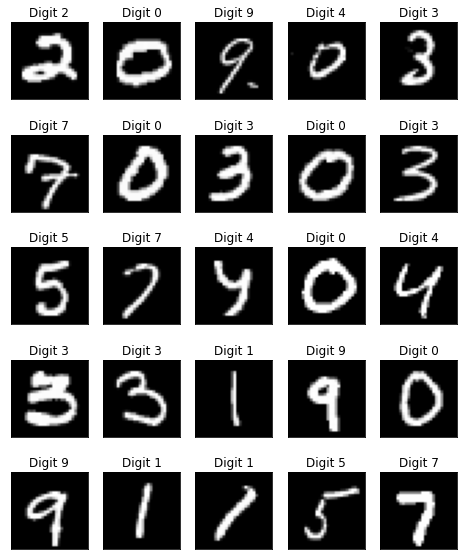

We have 28000 training images with (28, 28) H*W.
Value ranges for each image is between 0.0 and 1.0.
We have 10 classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].


In [15]:
plot_grid(X_submission.reshape(-1, 28, 28), predictions)

In [16]:
submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
submission['Label'] = predictions
submission.to_csv('submission.csv', index=False)